# BranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the incidence numbers for an example branching process model. The reproduction number profile is assumed to be a step function with only one jump.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import pandas as pd

num_timepoints = 30 # number of days for incidence data


/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


## Parameterize example branching process model

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
m = branchpro.BranchProModel(initial_r, serial_interval)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   67.   91.  136.  165.  264.  339.  491.  672.  946. 1236.
 1876. 2560. 3505. 4847. 1100. 1584. 1509. 1222.  991.  833.  685.  561.
  484.  386.  355.  327.  232.  230.]


## Compute the posterior distribution using explicit method

In [3]:
# Posterior of R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

i=0
for t in range(R_t_start,num_timepoints):
    shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
    sum_var = 0
    for k in range(t-tau,t+1):
        vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
        vec2 = serial_interval[:k] # w_1, ... , w_k
        sum_var += math.fsum( np.multiply(vec1,vec2) )
    rate.append( 1/b + sum_var )
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape,scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)


## Inference plot using explicit calculation results

In [4]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [5]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [6]:
# Same inference, but using the BranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [8]:
# Same inference, but using the BranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference_new = branchpro.PoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau = tau,
    alpha=a,
    beta=1/b)



In [25]:
post_dist.pdf([[0.4] * np.arange(R_t_start, num_timepoints)])

array([[5.32307126e-002, 1.29083260e+000, 6.46741681e-013,
        9.24885494e-052, 1.16966301e-155, 9.54534828e-321,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000]])

In [17]:
examples_r_profiles = [[_] * np.arange(R_t_start, num_timepoints) for _ in np.arange(0.4, 2, 0.2)]

for _, x in enumerate(examples_r_profiles): 
    if inference_new.return_logposterior(x) != np.sum([np.log(inference.inference_posterior.pdf(x0)) for x0 in x]):
        print('Different at {}'.format(_))
        print(inference_new.return_logposterior(x), inference.inference_posterior.big_pdf(x))

Different at 0
-1104762.6318512333 [9.63152011e-002 8.14377832e-001 5.16554904e-014 1.93172693e-054
 2.59151013e-161 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Different at 1
-1763174.3664877883 [2.08784582e-026 2.76803443e-081 1.42548595e-188 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Different at 2
-2443492.332360002 [2.14646185e-105 3.41703692e-241 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_89614/4052237093.py:4: RuntimeWarning:

divide by zero encountered in log



Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.


/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:04.1
1     6      0         0.5       0.5        0:04.1
2     9      0.333     0.333     0.667      0:04.1
3     12     0.25      0.25      0.75       0:04.1
20    63     0.19      0.381     0.286      0:04.1
40    123    0.317     0.317     0.366      0:04.2
60    183    0.377     0.344     0.361      0:04.2
80    243    0.382716  0.333     0.382716   0:04.3
100   303    0.376     0.327     0.416      0:04.3
120   363    0.38      0.331     0.446281   0:04.3
140   423    0.397     0.326     0.411      0:04.4
160   483    0.385     0.329     0.404      0:04.4
180   543    0.359116  0.337     0.392      0:04.4
Initial phase completed.
200   603    0.363     0.313     0.388      0:04.5
220   663    0.357     0.321267  0.389      0:04.5
240   723    0.365     0.315     0.386      0:04.6
260   783    0.356     0.307     0.364      0:04.6
280   843    0.338     0.32      0.359      0:04.7
300   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

500   1503   0.287     0.257485  0.273      0:08.3
520   1563   0.292     0.259     0.273      0:08.3
540   1623   0.294     0.257     0.266      0:08.4
560   1683   0.289     0.264     0.269      0:08.4
580   1743   0.292599  0.27      0.27       0:08.5
600   1803   0.288     0.275     0.275      0:08.5
620   1863   0.287     0.277     0.279      0:08.6
640   1923   0.285     0.276131  0.284      0:08.6
660   1983   0.283     0.274     0.281      0:08.7
680   2043   0.28      0.27      0.28       0:08.7
700   2103   0.28      0.265     0.278174   0:08.7
720   2163   0.276     0.259362  0.275      0:08.8
740   2223   0.274     0.255     0.275      0:08.8
760   2283   0.28      0.252     0.269      0:08.9
780   2343   0.282     0.25      0.265      0:08.9
800   2403   0.283     0.248     0.263      0:09.0
820   2463   0.28      0.245     0.258      0:09.0
840   2523   0.274673  0.244     0.252      0:09.1
860   2583   0.271     0.246     0.249      0:09.1
880   2643   0.266     0.245   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

1000  3003   0.262     0.256     0.233      0:12.6
1020  3063   0.26      0.255     0.237      0:12.7
1040  3123   0.256     0.256     0.237      0:12.7
1060  3183   0.254     0.254     0.237      0:12.7
1080  3243   0.254     0.253     0.234      0:12.8
1100  3303   0.258     0.25      0.232      0:12.8
1120  3363   0.258     0.252     0.227      0:12.9
1140  3423   0.258     0.254163  0.224      0:12.9
1160  3483   0.26      0.261     0.22       0:13.0
1180  3543   0.257409  0.261     0.217      0:13.0
1200  3603   0.257     0.264     0.214821   0:13.1
1220  3663   0.257     0.26      0.214      0:13.1
1240  3723   0.256245  0.263     0.211      0:13.2
1260  3783   0.255     0.266     0.209      0:13.2
1280  3843   0.253708  0.265     0.206089   0:13.3
1300  3903   0.251     0.264     0.206      0:13.3
1320  3963   0.251     0.263     0.206      0:13.4
1340  4023   0.248     0.261     0.207      0:13.4
1360  4083   0.247     0.259     0.206      0:13.4
1380  4143   0.248     0.257   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

1500  4503   0.244     0.251     0.219      0:17.0
1520  4563   0.242     0.25      0.222      0:17.0
1540  4623   0.241     0.249     0.227      0:17.1
1560  4683   0.238     0.249     0.231262   0:17.1
1580  4743   0.237     0.249     0.233      0:17.2
1600  4803   0.233604  0.249     0.235      0:17.2
1620  4863   0.231     0.247     0.239      0:17.3
1640  4923   0.229     0.246     0.24       0:17.3
1660  4983   0.226     0.243829  0.242      0:17.4
1680  5043   0.224     0.240928  0.244      0:17.4
1700  5103   0.222     0.239     0.244      0:17.4
1720  5163   0.219     0.237     0.248      0:17.5
1740  5223   0.217     0.236     0.25       0:17.5
1760  5283   0.215     0.235     0.252      0:17.6
1780  5343   0.216     0.233     0.254      0:17.6
1800  5403   0.218     0.231     0.255      0:17.7
1820  5463   0.216     0.231     0.255      0:17.7
1840  5523   0.218     0.229     0.258012   0:17.8
1860  5583   0.219     0.228     0.258      0:17.8
1880  5643   0.219     0.227   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

2000  6003   0.222     0.22      0.263      0:21.2
2020  6063   0.222662  0.219     0.264      0:21.2
2040  6123   0.223     0.219     0.265      0:21.3
2060  6183   0.225     0.219     0.264      0:21.3
2080  6243   0.225     0.219     0.265      0:21.4
2100  6303   0.227     0.219     0.265      0:21.4
2120  6363   0.228     0.221     0.264      0:21.5
2140  6423   0.228865  0.221     0.266      0:21.5
2160  6483   0.229     0.22      0.264      0:21.6
2180  6543   0.23      0.219     0.263      0:21.6
2200  6603   0.23      0.218     0.26       0:21.7
2220  6663   0.23      0.221     0.258      0:21.7
2240  6723   0.23      0.22      0.257      0:21.7
2260  6783   0.231     0.221     0.255      0:21.8
2280  6843   0.232     0.221     0.253      0:21.8
2300  6903   0.233     0.219     0.25       0:21.9
2320  6963   0.23352   0.219302  0.249      0:21.9
2340  7023   0.235     0.22      0.246903   0:22.0
2360  7083   0.235     0.22      0.246      0:22.0
2380  7143   0.234     0.22    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

2500  7503   0.236     0.227509  0.238      0:25.5
2520  7563   0.236     0.228     0.239      0:25.6
2540  7623   0.236     0.23      0.238      0:25.6
2560  7683   0.236     0.229     0.237      0:25.7
2580  7743   0.235     0.228981  0.239      0:25.7
2600  7803   0.234     0.228     0.239      0:25.8
2620  7863   0.232     0.229     0.239      0:25.8
2640  7923   0.232     0.23      0.239      0:25.8
2660  7983   0.23      0.229     0.24       0:25.9
2680  8043   0.231257  0.229019  0.239      0:25.9
2700  8103   0.23      0.23      0.24       0:26.0
2720  8163   0.23      0.23      0.24       0:26.0
2740  8223   0.229     0.229     0.24       0:26.1
2760  8283   0.227816  0.229     0.242      0:26.1
2780  8343   0.226     0.228     0.241      0:26.2
2800  8403   0.225     0.227     0.242      0:26.2
2820  8463   0.224     0.228     0.242      0:26.3
2840  8523   0.222     0.228     0.243      0:26.3
2860  8583   0.221     0.230339  0.243      0:26.4
2880  8643   0.219     0.231   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

3000  9003   0.214     0.235     0.245918   0:29.9
3020  9063   0.213     0.236     0.247      0:29.9
3040  9123   0.212759  0.23512   0.248      0:30.0
3060  9183   0.212     0.235     0.248      0:30.0
3080  9243   0.212     0.235     0.248      0:30.1
3100  9303   0.213     0.235     0.248      0:30.1
3120  9363   0.213     0.235     0.248      0:30.2
3140  9423   0.212     0.234957  0.248      0:30.2
3160  9483   0.211     0.234     0.248      0:30.3
3180  9543   0.212     0.235     0.248      0:30.3
3200  9603   0.211     0.234     0.247      0:30.3
3220  9663   0.21      0.235     0.247      0:30.4
3240  9723   0.21      0.236     0.247      0:30.4
3260  9783   0.21      0.235     0.247      0:30.5
3280  9843   0.21      0.236     0.248      0:30.5
3300  9903   0.211     0.236595  0.248      0:30.6
3320  9963   0.21      0.237     0.248      0:30.6
3340  10023  0.211     0.238     0.248      0:30.7
3360  10083  0.211     0.238     0.248      0:30.7
3380  10143  0.21      0.238   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

3500  10503  0.211     0.238     0.244      0:34.2
3520  10563  0.212     0.238     0.243      0:34.2
3540  10623  0.212087  0.238     0.242022   0:34.3
3560  10683  0.213     0.238697  0.241      0:34.3
3580  10743  0.213     0.24      0.24       0:34.4
3600  10803  0.213     0.24      0.239      0:34.4
3620  10863  0.214     0.241     0.238332   0:34.5
3640  10923  0.214     0.241     0.237      0:34.5
3660  10983  0.213     0.24      0.236      0:34.6
3680  11043  0.213     0.239     0.236      0:34.6
3700  11103  0.213     0.239     0.234261   0:34.6
3720  11163  0.213     0.239183  0.234      0:34.7
3740  11223  0.213     0.24      0.233      0:34.8
3760  11283  0.213507  0.24      0.232      0:34.8
3780  11343  0.214     0.24      0.231      0:34.8
3800  11403  0.214     0.239     0.23       0:34.9
3820  11463  0.215     0.238     0.23       0:34.9
3840  11523  0.215     0.238     0.229      0:35.0
3860  11583  0.215     0.237     0.228      0:35.0
3880  11643  0.217     0.236   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

4000  12003  0.223     0.235     0.222      0:40.4
4020  12063  0.224     0.235     0.221338   0:40.5
4040  12123  0.224     0.235     0.22       0:40.5
4060  12183  0.225     0.235     0.22       0:40.6
4080  12243  0.226     0.235     0.219      0:40.6
4100  12303  0.226774  0.234     0.218      0:40.7
4120  12363  0.226     0.234     0.217423   0:40.7
4140  12423  0.227     0.233     0.218      0:40.7
4160  12483  0.227     0.232     0.218      0:40.8
4180  12543  0.227     0.232     0.217      0:40.8
4200  12603  0.227     0.231     0.217      0:40.9
4220  12663  0.227     0.230751  0.217      0:40.9
4240  12723  0.227     0.230606  0.217      0:41.0
4260  12783  0.227     0.230697  0.216      0:41.0
4280  12843  0.227     0.23      0.215      0:41.1
4300  12903  0.227389  0.229714  0.214      0:41.1
4320  12963  0.228     0.23      0.213      0:41.2
4340  13023  0.228     0.23      0.212      0:41.2
4360  13083  0.228388  0.229     0.212      0:41.2
4380  13143  0.228     0.228   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

4500  13503  0.231     0.225     0.21       0:49.2
4520  13563  0.232     0.224729  0.21       0:49.3
4540  13623  0.231     0.224     0.21       0:49.3
4560  13683  0.231     0.223     0.211      0:49.4
4580  13743  0.232     0.222     0.211      0:49.4
4600  13803  0.232     0.222     0.211      0:49.5
4620  13863  0.232     0.222     0.212      0:49.5
4640  13923  0.233     0.221     0.212      0:49.5
4660  13983  0.233     0.220339  0.213      0:49.6
4680  14043  0.232429  0.219     0.213      0:49.6
4700  14103  0.233     0.219     0.214      0:49.7
4720  14163  0.233     0.218     0.214      0:49.7
4740  14223  0.233     0.217     0.215      0:49.8
4760  14283  0.233     0.216     0.215      0:49.8
4780  14343  0.234     0.216     0.215      0:49.9
4800  14403  0.234     0.215     0.215      0:49.9
4820  14463  0.234     0.214     0.216      0:50.0
4840  14523  0.234     0.214     0.217      0:50.0
4860  14583  0.234     0.213     0.218      0:50.0
4880  14643  0.234     0.212   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

5000  15003  0.235153  0.208     0.221      0:53.2
5020  15063  0.235     0.208     0.222      0:53.2
5040  15123  0.235     0.207     0.222      0:53.3
5060  15183  0.235     0.206     0.224      0:53.3
5080  15243  0.235     0.206     0.224      0:53.4
5100  15303  0.234     0.205     0.224      0:53.4
5120  15363  0.235     0.205     0.225      0:53.4
5140  15423  0.234     0.205     0.224859   0:53.5
5160  15483  0.235032  0.204224  0.226      0:53.5
5180  15543  0.235     0.204     0.226      0:53.6
5200  15603  0.235     0.203807  0.227      0:53.6
5220  15663  0.236     0.203     0.228      0:53.7
5240  15723  0.235     0.203     0.228      0:53.7
5260  15783  0.236     0.202433  0.228      0:53.8
5280  15843  0.236     0.202     0.229      0:53.8
5300  15903  0.236     0.202     0.229      0:53.9
5320  15963  0.236     0.202     0.229      0:53.9
5340  16023  0.236     0.202     0.23       0:53.9
5360  16083  0.236     0.202     0.231      0:54.0
5380  16143  0.235     0.202   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash

5500  16503  0.236     0.202     0.234      0:57.1
5520  16563  0.235     0.202     0.234      0:57.1
5540  16623  0.236     0.201     0.234      0:57.2
5560  16683  0.235     0.201     0.234      0:57.2
5580  16743  0.236     0.201756  0.234      0:57.3
5600  16803  0.236     0.202     0.235      0:57.3
5620  16863  0.236     0.201     0.235      0:57.4
5640  16923  0.236     0.201     0.235      0:57.4
5660  16983  0.236     0.201     0.235      0:57.4
5680  17043  0.236     0.202     0.235      0:57.5
5700  17103  0.235     0.202     0.235      0:57.5
5720  17163  0.235     0.201     0.235      0:57.6
5740  17223  0.235     0.201     0.235499   0:57.6
5760  17283  0.235     0.201     0.235      0:57.7
5780  17343  0.236     0.201     0.235      0:57.7
5800  17403  0.235     0.201     0.235      0:57.8
5820  17463  0.236     0.201     0.235      0:57.8
5840  17523  0.236     0.202     0.235      0:57.9
5860  17583  0.236     0.202     0.235      0:57.9
5880  17643  0.236     0.203   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

6000  18003  0.235     0.204     0.237      1:01.0
6020  18063  0.234     0.204     0.237      1:01.1
6040  18123  0.233     0.204933  0.237      1:01.1
6060  18183  0.233     0.205     0.237      1:01.2
6080  18243  0.233     0.205     0.238      1:01.2
6100  18303  0.232     0.205     0.237      1:01.3
6120  18363  0.231008  0.206     0.237      1:01.3
6140  18423  0.23      0.206     0.236      1:01.3
6160  18483  0.23      0.20646   0.236      1:01.4
6180  18543  0.229     0.207     0.235      1:01.4
6200  18603  0.228     0.207     0.234317   1:01.5
6220  18663  0.227     0.208     0.234046   1:01.5
6240  18723  0.227     0.208     0.234      1:01.6
6260  18783  0.226162  0.209     0.233      1:01.6
6280  18843  0.225     0.209     0.233      1:01.7
6300  18903  0.225     0.209     0.233      1:01.7
6320  18963  0.224     0.209     0.232      1:01.8
6340  19023  0.223     0.21      0.231      1:01.8
6360  19083  0.223     0.21      0.231      1:01.8
6380  19143  0.222     0.21    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

6500  19503  0.219     0.214     0.226      1:05.0
6520  19563  0.219     0.215     0.226      1:05.1
6540  19623  0.218     0.214     0.225      1:05.1
6560  19683  0.217     0.215     0.225      1:05.1
6580  19743  0.217     0.216     0.225      1:05.2
6600  19803  0.216     0.217     0.224      1:05.2
6620  19863  0.216     0.217     0.224      1:05.3
6640  19923  0.216     0.217136  0.222858   1:05.3
6660  19983  0.215283  0.217     0.222      1:05.4
6680  20043  0.215     0.218     0.222      1:05.4
6700  20103  0.215     0.219     0.221161   1:05.5
6720  20163  0.214     0.219     0.221      1:05.5
6740  20223  0.214     0.219     0.219997   1:05.6
6760  20283  0.214     0.219     0.219      1:05.6
6780  20343  0.213     0.219     0.219      1:05.6
6800  20403  0.213     0.219     0.218      1:05.7
6820  20463  0.213     0.22      0.218      1:05.7
6840  20523  0.212     0.22      0.217      1:05.8
6860  20583  0.211     0.219     0.217      1:05.8
6880  20643  0.211     0.22    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

7000  21003  0.209113  0.222     0.216      1:08.9
7020  21063  0.209     0.221     0.216      1:09.0
7040  21123  0.208     0.222     0.215      1:09.0
7060  21183  0.208     0.222     0.215      1:09.0
7080  21243  0.208     0.222     0.216      1:09.1
7100  21303  0.208     0.222     0.215      1:09.1
7120  21363  0.208     0.222     0.2157     1:09.2
7140  21423  0.208     0.223     0.216      1:09.2
7160  21483  0.208     0.223     0.216      1:09.3
7180  21543  0.208     0.222     0.216      1:09.3
7200  21603  0.208     0.222608  0.217      1:09.4
7220  21663  0.207589  0.223     0.217006   1:09.4
7240  21723  0.208     0.223     0.217      1:09.5
7260  21783  0.207     0.223     0.21705    1:09.5
7280  21843  0.207     0.223     0.217      1:09.5
7300  21903  0.206821  0.223     0.217      1:09.6
7320  21963  0.207     0.223     0.217      1:09.6
7340  22023  0.207     0.223     0.216728   1:09.7
7360  22083  0.207     0.223     0.217      1:09.7
7380  22143  0.207     0.224   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

7500  22503  0.207     0.226     0.216      1:12.8
7520  22563  0.208217  0.226     0.217      1:12.9
7540  22623  0.208     0.227     0.217      1:12.9
7560  22683  0.209     0.226     0.217      1:13.0
7580  22743  0.209     0.226     0.217      1:13.0
7600  22803  0.209     0.226286  0.217      1:13.1
7620  22863  0.209     0.226     0.218      1:13.1
7640  22923  0.21      0.226     0.218      1:13.2
7660  22983  0.21      0.226     0.218      1:13.2
7680  23043  0.209     0.226     0.219      1:13.3
7700  23103  0.209     0.226     0.219452   1:13.3
7720  23163  0.209     0.225     0.22       1:13.3
7740  23223  0.209     0.225     0.219      1:13.4
7760  23283  0.21      0.224     0.219817   1:13.4
7780  23343  0.21      0.224     0.22       1:13.5
7800  23403  0.21      0.224     0.22       1:13.5
7820  23463  0.211     0.223373  0.22       1:13.6
7840  23523  0.211     0.224     0.221      1:13.6
7860  23583  0.211     0.224     0.221      1:13.7
7880  23643  0.211     0.223   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

8000  24003  0.213     0.221     0.224347   1:16.8
8020  24063  0.213315  0.220172  0.225      1:16.9
8040  24123  0.213     0.22      0.225      1:16.9
8060  24183  0.214     0.22      0.224662   1:17.0
8080  24243  0.214     0.219156  0.225      1:17.0
8100  24303  0.215     0.219     0.225      1:17.1
8120  24363  0.215     0.218     0.224      1:17.1
8140  24423  0.215     0.218     0.225      1:17.2
8160  24483  0.216     0.218     0.225      1:17.2
8180  24543  0.215     0.217     0.225      1:17.3
8200  24603  0.215     0.217     0.225      1:17.3
8220  24663  0.216     0.217     0.225      1:17.4
8240  24723  0.216     0.216     0.225      1:17.4
8260  24783  0.216     0.215     0.225      1:17.5
8280  24843  0.216     0.215     0.225      1:17.5
8300  24903  0.216     0.215     0.225      1:17.6
8320  24963  0.215     0.214     0.225      1:17.6
8340  25023  0.216     0.214     0.225      1:17.6
8360  25083  0.217     0.213     0.225      1:17.7
8380  25143  0.217     0.213   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

8500  25503  0.218092  0.211     0.223      1:20.8
8520  25563  0.219     0.21      0.222157   1:20.9
8540  25623  0.219     0.21      0.221871   1:20.9
8560  25683  0.22      0.21      0.222      1:20.9
8580  25743  0.22      0.209     0.221      1:21.0
8600  25803  0.220672  0.209     0.220672   1:21.0
8620  25863  0.221     0.209     0.22       1:21.1
8640  25923  0.222     0.209     0.22       1:21.1
8660  25983  0.222     0.208     0.22       1:21.2
8680  26043  0.222     0.208     0.219      1:21.2
8700  26103  0.222     0.208     0.219      1:21.3
8720  26163  0.223     0.208     0.218      1:21.3
8740  26223  0.223     0.208     0.218      1:21.4
8760  26283  0.223     0.207853  0.218      1:21.4
8780  26343  0.224     0.208     0.217629   1:21.5
8800  26403  0.223     0.207     0.218      1:21.5
8820  26463  0.223     0.207     0.217      1:21.5
8840  26523  0.223     0.207     0.217      1:21.6
8860  26583  0.223     0.207     0.217      1:21.6
8880  26643  0.223     0.207   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

9000  27003  0.224     0.206     0.216      1:24.7
9020  27063  0.224     0.206     0.216384   1:24.8
9040  27123  0.225     0.206     0.217      1:24.8
9060  27183  0.22492   0.206     0.216422   1:24.9
9080  27243  0.225     0.205484  0.216496   1:24.9
9100  27303  0.226     0.206     0.217      1:25.0
9120  27363  0.227     0.206     0.217      1:25.0
9140  27423  0.226     0.206     0.217      1:25.1
9160  27483  0.227     0.206     0.217116   1:25.1
9180  27543  0.227     0.206     0.217      1:25.2
9200  27603  0.227     0.206     0.217      1:25.2
9220  27663  0.227     0.206     0.217      1:25.2
9240  27723  0.228     0.206     0.217      1:25.3
9260  27783  0.227     0.206     0.218      1:25.3
9280  27843  0.228     0.206     0.218      1:25.4
9300  27903  0.228     0.207     0.218      1:25.4
9320  27963  0.227     0.206     0.218      1:25.5
9340  28023  0.227     0.206     0.219      1:25.5
9360  28083  0.227     0.207     0.219      1:25.6
9380  28143  0.228     0.208   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

9500  28503  0.23      0.209     0.22       1:28.7
9520  28563  0.229     0.21      0.22       1:28.8
9540  28623  0.229     0.21      0.22       1:28.8
9560  28683  0.23      0.209     0.221      1:28.9
9580  28743  0.23      0.209     0.221      1:28.9
9600  28803  0.23      0.209     0.222      1:29.0
9620  28863  0.23      0.21      0.222      1:29.0
9640  28923  0.229748  0.209833  0.221865   1:29.1
9660  28983  0.23      0.21      0.222      1:29.1
9680  29043  0.229625  0.209999  0.223      1:29.1
9700  29103  0.229     0.21      0.223      1:29.2
9720  29163  0.23      0.21      0.223      1:29.2
9740  29223  0.23      0.211     0.223      1:29.3
9760  29283  0.229     0.211     0.224      1:29.3
9780  29343  0.229     0.211     0.224      1:29.4
9800  29403  0.229     0.21      0.224      1:29.4
9820  29463  0.229     0.21      0.224      1:29.5
9840  29523  0.228     0.211     0.224      1:29.5
9860  29583  0.228     0.210932  0.225      1:29.6
9880  29643  0.227811  0.211   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

10000 30003  0.227     0.213     0.226      1:32.7
10020 30063  0.227     0.213     0.225726   1:32.7
10040 30123  0.227     0.213425  0.226      1:32.7
10060 30183  0.227     0.214     0.226      1:32.8
10080 30243  0.227     0.214     0.226168   1:32.8
10100 30303  0.227     0.215     0.226      1:32.9
10120 30363  0.227     0.215     0.226      1:32.9
10140 30423  0.226     0.215     0.226      1:33.0
10160 30483  0.225962  0.215     0.226      1:33.0
10180 30543  0.226     0.215     0.227      1:33.1
10200 30603  0.226     0.216     0.227      1:33.1
10220 30663  0.226     0.216     0.226788   1:33.2
10240 30723  0.225271  0.216     0.227      1:33.2
10260 30783  0.225     0.217     0.226      1:33.3
10280 30843  0.226     0.217     0.226      1:33.3
10300 30903  0.226     0.217     0.226      1:33.3
10320 30963  0.225     0.218     0.227      1:33.4
10340 31023  0.225     0.218     0.227      1:33.4
10360 31083  0.225     0.218     0.227      1:33.5
10380 31143  0.225     0.218   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

10500 31503  0.226     0.221     0.228      1:36.7
10520 31563  0.225739  0.221     0.228      1:36.7
10540 31623  0.226     0.221     0.228      1:36.8
10560 31683  0.226     0.221     0.227914   1:36.8
10580 31743  0.226     0.221     0.228      1:36.9
10600 31803  0.226     0.221     0.229      1:36.9
10620 31863  0.226     0.222     0.229      1:37.0
10640 31923  0.226     0.222     0.229      1:37.0
10660 31983  0.226     0.222     0.23       1:37.1
10680 32043  0.227     0.222     0.229941   1:37.1
10700 32103  0.227     0.221755  0.23       1:37.2
10720 32163  0.227     0.222     0.231      1:37.2
10740 32223  0.227     0.222     0.231      1:37.3
10760 32283  0.227     0.22247   0.231      1:37.3
10780 32343  0.227     0.223     0.231      1:37.3
10800 32403  0.227     0.223     0.231      1:37.4
10820 32463  0.228     0.223     0.231      1:37.4
10840 32523  0.227562  0.223     0.231      1:37.5
10860 32583  0.228     0.224     0.231      1:37.5
10880 32643  0.227     0.224   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

11000 33003  0.228     0.225     0.229      1:40.7
11020 33063  0.228     0.225     0.229      1:40.8
11040 33123  0.228     0.226     0.229      1:40.8
11060 33183  0.228     0.226     0.228      1:40.9
11080 33243  0.228     0.226     0.228      1:40.9
11100 33303  0.228     0.226     0.227457   1:41.0
11120 33363  0.228     0.226     0.227      1:41.0
11140 33423  0.229     0.226     0.227      1:41.0
11160 33483  0.228     0.226503  0.227      1:41.1
11180 33543  0.229     0.227     0.226      1:41.1
11200 33603  0.229     0.227     0.226      1:41.2
11220 33663  0.229     0.227     0.226      1:41.2
11240 33723  0.229     0.227115  0.226      1:41.3
11260 33783  0.229     0.227     0.226      1:41.3
11280 33843  0.229     0.228     0.225246   1:41.4
11300 33903  0.229     0.228     0.225      1:41.4
11320 33963  0.229     0.228     0.225      1:41.5
11340 34023  0.229     0.228     0.224407   1:41.5
11360 34083  0.229     0.228589  0.2241     1:41.5
11380 34143  0.229     0.229   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

11500 34503  0.23      0.229     0.222      1:44.7
11520 34563  0.229     0.229     0.222      1:44.7
11540 34623  0.229     0.229     0.221      1:44.8
11560 34683  0.229     0.229     0.221      1:44.8
11580 34743  0.229     0.229     0.221      1:44.8
11600 34803  0.23      0.229     0.22       1:44.9
11620 34863  0.229     0.23      0.22       1:44.9
11640 34923  0.229     0.229     0.219      1:45.0
11660 34983  0.229     0.229     0.219      1:45.0
11680 35043  0.229     0.23      0.219      1:45.1
11700 35103  0.229     0.229553  0.219      1:45.1
11720 35163  0.23      0.23      0.218582   1:45.2
11740 35223  0.23      0.229282  0.218      1:45.2
11760 35283  0.23      0.229     0.218      1:45.3
11780 35343  0.23      0.229607  0.218      1:45.3
11800 35403  0.23      0.229811  0.218      1:45.3
11820 35463  0.23      0.23      0.217      1:45.4
11840 35523  0.23      0.23      0.217      1:45.4
11860 35583  0.23      0.23      0.217      1:45.5
11880 35643  0.231     0.23    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

12000 36003  0.229     0.23      0.215482   1:48.6
12020 36063  0.229     0.231     0.215      1:48.6
12040 36123  0.229     0.231     0.215      1:48.6
12060 36183  0.229     0.23      0.215      1:48.7
12080 36243  0.229     0.23      0.215      1:48.7
12100 36303  0.229     0.23      0.215      1:48.8
12120 36363  0.229519  0.229849  0.214      1:48.8
12140 36423  0.229     0.23      0.214      1:48.9
12160 36483  0.229     0.23      0.214      1:48.9
12180 36543  0.23      0.23      0.214      1:49.0
12200 36603  0.23      0.23      0.214      1:49.0
12220 36663  0.23      0.23      0.214      1:49.1
12240 36723  0.23      0.230455  0.214      1:49.1
12260 36783  0.23      0.23      0.214      1:49.1
12280 36843  0.23      0.231     0.214      1:49.2
12300 36903  0.23      0.231     0.214      1:49.2
12320 36963  0.230095  0.231     0.214      1:49.3
12340 37023  0.23      0.231     0.214      1:49.3
12360 37083  0.23      0.231     0.215      1:49.4
12380 37143  0.23      0.231   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

12500 37503  0.23      0.231     0.213      1:52.5
12520 37563  0.231     0.231     0.213      1:52.6
12540 37623  0.231     0.231     0.213      1:52.6
12560 37683  0.231     0.231     0.213      1:52.6
12580 37743  0.231     0.231     0.213576   1:52.7
12600 37803  0.231     0.231     0.214      1:52.7
12620 37863  0.231202  0.231     0.213      1:52.8
12640 37923  0.231     0.231     0.213      1:52.8
12660 37983  0.231     0.231     0.213      1:52.9
12680 38043  0.231212  0.231     0.213      1:52.9
12700 38103  0.232     0.231     0.213      1:53.0
12720 38163  0.231     0.231     0.214      1:53.0
12740 38223  0.231     0.231     0.213484   1:53.1
12760 38283  0.231     0.231     0.213      1:53.1
12780 38343  0.231672  0.231     0.213      1:53.2
12800 38403  0.232     0.231     0.213      1:53.2
12820 38463  0.232     0.231     0.213      1:53.2
12840 38523  0.232     0.231     0.213379   1:53.3
12860 38583  0.232     0.231     0.214      1:53.3
12880 38643  0.232     0.231   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

13000 39003  0.232     0.231     0.215      1:56.4
13020 39063  0.232     0.231165  0.215      1:56.5
13040 39123  0.232     0.231     0.215      1:56.5
13060 39183  0.232     0.232     0.215      1:56.6
13080 39243  0.232     0.232     0.215427   1:56.6
13100 39303  0.232654  0.232     0.216      1:56.7
13120 39363  0.232     0.232     0.216      1:56.7
13140 39423  0.232     0.232     0.216      1:56.8
13160 39483  0.232     0.232     0.216169   1:56.8
13180 39543  0.232     0.232     0.216      1:56.9
13200 39603  0.232     0.232     0.216      1:56.9
13220 39663  0.232     0.232     0.217      1:57.0
13240 39723  0.232     0.231     0.217      1:57.0
13260 39783  0.232     0.231     0.217      1:57.0
13280 39843  0.232     0.231     0.218      1:57.1
13300 39903  0.233     0.23      0.218      1:57.1
13320 39963  0.233     0.230313  0.218377   1:57.2
13340 40023  0.233     0.23      0.219      1:57.2
13360 40083  0.233     0.23      0.219      1:57.3
13380 40143  0.233     0.23    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

13500 40503  0.233     0.229     0.22       2:00.4
13520 40563  0.232897  0.228     0.22       2:00.4
13540 40623  0.232553  0.228     0.22       2:00.5
13560 40683  0.232     0.228     0.221      2:00.5
13580 40743  0.232     0.228     0.221      2:00.6
13600 40803  0.232     0.228     0.221      2:00.6
13620 40863  0.231     0.228     0.221      2:00.7
13640 40923  0.231288  0.228     0.221      2:00.7
13660 40983  0.231     0.228     0.221      2:00.8
13680 41043  0.231     0.228     0.221      2:00.8
13700 41103  0.23      0.228     0.221      2:00.9
13720 41163  0.23      0.227     0.221      2:00.9
13740 41223  0.23      0.227     0.221454   2:01.0
13760 41283  0.23      0.227     0.222      2:01.0
13780 41343  0.23      0.227     0.222      2:01.0
13800 41403  0.229     0.226288  0.222      2:01.1
13820 41463  0.229     0.226     0.222      2:01.1
13840 41523  0.229     0.226     0.222      2:01.2
13860 41583  0.229     0.225     0.223      2:01.2
13880 41643  0.228     0.225   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

14000 42003  0.227     0.224     0.224      2:04.4
14020 42063  0.227     0.223     0.224449   2:04.4
14040 42123  0.227     0.223     0.224      2:04.5
14060 42183  0.226     0.223     0.225      2:04.5
14080 42243  0.226     0.223     0.224984   2:04.5
14100 42303  0.226     0.223     0.225      2:04.6
14120 42363  0.226     0.223     0.226      2:04.6
14140 42423  0.225     0.222     0.226      2:04.7
14160 42483  0.225     0.222     0.226      2:04.7
14180 42543  0.225     0.222     0.226      2:04.8
14200 42603  0.224     0.222     0.226      2:04.8
14220 42663  0.224     0.222     0.226496   2:04.8
14240 42723  0.224     0.222     0.227      2:04.9
14260 42783  0.223687  0.222     0.227      2:04.9
14280 42843  0.223     0.221     0.227155   2:05.0
14300 42903  0.223     0.221     0.227      2:05.0
14320 42963  0.223     0.221     0.227      2:05.1
14340 43023  0.223     0.221     0.227      2:05.1
14360 43083  0.223     0.221     0.228      2:05.2
14380 43143  0.222     0.22    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

14500 43503  0.221     0.219     0.229      2:08.3
14520 43563  0.221     0.218     0.229      2:08.4
14540 43623  0.22048   0.218073  0.229      2:08.4
14560 43683  0.22      0.218     0.23       2:08.5
14580 43743  0.22      0.218     0.229      2:08.5
14600 43803  0.22      0.217     0.23       2:08.5
14620 43863  0.22      0.217     0.23       2:08.6
14640 43923  0.22      0.217     0.23       2:08.6
14660 43983  0.219     0.216     0.23       2:08.7
14680 44043  0.219     0.216     0.23       2:08.7
14700 44103  0.219     0.216     0.23       2:08.8
14720 44163  0.219     0.216     0.23       2:08.8
14740 44223  0.219     0.215     0.23       2:08.9
14760 44283  0.219     0.215     0.23       2:08.9
14780 44343  0.219     0.215     0.230431   2:09.0
14800 44403  0.219     0.215     0.23       2:09.0
14820 44463  0.219     0.215     0.23       2:09.0
14840 44523  0.218     0.214     0.231      2:09.1
14860 44583  0.218     0.214     0.231      2:09.1
14880 44643  0.218     0.214   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash 

15000 45003  0.218     0.214     0.231      2:12.3
15020 45063  0.218     0.214     0.231      2:12.3
15040 45123  0.218     0.214     0.231      2:12.4
15060 45183  0.218     0.214     0.231      2:12.4
15080 45243  0.218     0.213     0.231      2:12.5
15100 45303  0.218     0.213     0.231      2:12.5
15120 45363  0.218     0.213     0.231      2:12.6
15140 45423  0.218     0.213     0.231      2:12.6
15160 45483  0.218     0.213     0.231      2:12.7
15180 45543  0.218     0.213     0.231      2:12.7
15200 45603  0.218     0.212486  0.231      2:12.8
15220 45663  0.218     0.212     0.232      2:12.8
15240 45723  0.219     0.211994  0.232      2:12.8
15260 45783  0.219     0.212     0.231      2:12.9
15280 45843  0.219     0.212     0.231333   2:12.9
15300 45903  0.218     0.211     0.231      2:13.0
15320 45963  0.218     0.211     0.232      2:13.0
15340 46023  0.218     0.211     0.231732   2:13.1
15360 46083  0.218     0.211     0.232      2:13.1
15380 46143  0.218     0.211   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

15500 46503  0.217     0.209     0.231856   2:16.2
15520 46563  0.216803  0.209     0.232      2:16.3
15540 46623  0.216524  0.209     0.232      2:16.3
15560 46683  0.216     0.209     0.232      2:16.4
15580 46743  0.216     0.209     0.231885   2:16.4
15600 46803  0.21614   0.20832   0.232      2:16.5
15620 46863  0.216     0.208     0.232      2:16.5
15640 46923  0.215779  0.208     0.232      2:16.6
15660 46983  0.216     0.208     0.232      2:16.6
15680 47043  0.215     0.208     0.232      2:16.7
15700 47103  0.215     0.208     0.233      2:16.7
15720 47163  0.214681  0.208     0.233      2:16.7
15740 47223  0.214     0.208     0.233      2:16.8
15760 47283  0.214     0.207601  0.232      2:16.8
15780 47343  0.214     0.207     0.232368   2:16.9
15800 47403  0.214     0.207     0.232      2:16.9
15820 47463  0.214     0.207     0.232      2:17.0
15840 47523  0.213     0.207247  0.232      2:17.0
15860 47583  0.213     0.207     0.233      2:17.1
15880 47643  0.213     0.206788

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

16000 48003  0.212     0.206     0.233      2:20.2
16020 48063  0.212     0.206     0.233      2:20.3
16040 48123  0.212     0.206     0.233      2:20.3
16060 48183  0.212     0.206     0.233      2:20.3
16080 48243  0.211     0.205     0.233      2:20.4
16100 48303  0.211     0.205     0.233029   2:20.4
16120 48363  0.211     0.205     0.233      2:20.5
16140 48423  0.211     0.205     0.233      2:20.5
16160 48483  0.211     0.205     0.233      2:20.6
16180 48543  0.211     0.205     0.234      2:20.6
16200 48603  0.211     0.205     0.234      2:20.7
16220 48663  0.211     0.204673  0.234      2:20.7
16240 48723  0.210455  0.205     0.234      2:20.8
16260 48783  0.21      0.204     0.234      2:20.8
16280 48843  0.21      0.204     0.234      2:20.8
16300 48903  0.21      0.204     0.234      2:20.9
16320 48963  0.21      0.204     0.234      2:20.9
16340 49023  0.209     0.204     0.234      2:21.0
16360 49083  0.209217  0.204144  0.234      2:21.0
16380 49143  0.209     0.204   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

16500 49503  0.20926   0.204     0.235      2:24.1
16520 49563  0.209     0.204     0.235      2:24.2
16540 49623  0.209     0.204     0.235      2:24.2
16560 49683  0.21      0.204     0.235      2:24.3
16580 49743  0.21      0.204     0.235209   2:24.3
16600 49803  0.21      0.204     0.235      2:24.4
16620 49863  0.209855  0.204     0.235      2:24.4
16640 49923  0.21      0.204     0.235082   2:24.5
16660 49983  0.21      0.204     0.235      2:24.5
16680 50043  0.21      0.204     0.235      2:24.5
16700 50103  0.21      0.204838  0.235      2:24.6
16720 50163  0.21      0.205     0.235      2:24.6
16740 50223  0.21      0.205     0.235      2:24.7
16760 50283  0.210608  0.205     0.235      2:24.7
16780 50343  0.211     0.205     0.235      2:24.8
16800 50403  0.211     0.205     0.235      2:24.8
16820 50463  0.211     0.205     0.234      2:24.9
16840 50523  0.211     0.204976  0.234      2:24.9
16860 50583  0.211     0.205     0.234      2:25.0
16880 50643  0.211     0.205   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

17000 51003  0.212     0.204635  0.234      2:28.1
17020 51063  0.212     0.204     0.235      2:28.1
17040 51123  0.212     0.204272  0.235      2:28.2
17060 51183  0.212     0.204267  0.235      2:28.2
17080 51243  0.212     0.204145  0.234      2:28.3
17100 51303  0.212     0.204     0.234      2:28.3
17120 51363  0.212     0.204     0.234      2:28.4
17140 51423  0.212     0.204     0.234      2:28.4
17160 51483  0.213     0.204     0.234      2:28.5
17180 51543  0.212444  0.203     0.235      2:28.5
17200 51603  0.213     0.203     0.235      2:28.5
17220 51663  0.213     0.203     0.235      2:28.6
17240 51723  0.213     0.203     0.235      2:28.6
17260 51783  0.213     0.203     0.235      2:28.7
17280 51843  0.214     0.202766  0.234998   2:28.7
17300 51903  0.214     0.203     0.235      2:28.8
17320 51963  0.214     0.203     0.235      2:28.8
17340 52023  0.215     0.203     0.234      2:28.9
17360 52083  0.215     0.202     0.234      2:28.9
17380 52143  0.215     0.202   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

17500 52503  0.216     0.202     0.233      2:32.0
17520 52563  0.216     0.202     0.233      2:32.1
17540 52623  0.217     0.202     0.233      2:32.1
17560 52683  0.217     0.202     0.232      2:32.2
17580 52743  0.217     0.202     0.232      2:32.2
17600 52803  0.217     0.202     0.232      2:32.3
17620 52863  0.216957  0.202     0.232      2:32.3
17640 52923  0.217     0.202     0.231      2:32.4
17660 52983  0.216862  0.202     0.231244   2:32.4
17680 53043  0.217     0.202     0.231      2:32.5
17700 53103  0.217     0.201627  0.231      2:32.5
17720 53163  0.217     0.202     0.231      2:32.5
17740 53223  0.217     0.202187  0.231      2:32.6
17760 53283  0.217     0.202     0.231      2:32.6
17780 53343  0.217     0.202     0.230527   2:32.7
17800 53403  0.217     0.202     0.23       2:32.7
17820 53463  0.217     0.202     0.23       2:32.8
17840 53523  0.217     0.202455  0.23       2:32.8
17860 53583  0.217457  0.202     0.23       2:32.9
17880 53643  0.218     0.202   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash

18000 54003  0.218     0.203     0.229      2:36.0
18020 54063  0.218     0.203     0.229      2:36.0
18040 54123  0.218     0.204     0.229      2:36.1
18060 54183  0.219     0.204     0.229      2:36.1
18080 54243  0.219     0.204     0.229      2:36.1
18100 54303  0.219     0.204     0.228      2:36.2
18120 54363  0.219     0.204     0.228      2:36.2
18140 54423  0.219     0.204     0.228      2:36.3
18160 54483  0.219     0.205     0.228      2:36.3
18180 54543  0.219     0.205     0.228      2:36.4
18200 54603  0.219     0.205     0.228      2:36.4
18220 54663  0.219     0.205     0.228      2:36.5
18240 54723  0.219     0.206     0.228      2:36.5
18260 54783  0.219     0.206     0.228      2:36.6
18280 54843  0.219     0.206     0.228      2:36.6
18300 54903  0.22      0.206     0.228      2:36.7
18320 54963  0.219857  0.207     0.227      2:36.7
18340 55023  0.22      0.207     0.227      2:36.7
18360 55083  0.22      0.207     0.227      2:36.8
18380 55143  0.22      0.207   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

18500 55503  0.22      0.209     0.227      2:39.9
18520 55563  0.22      0.209276  0.227      2:40.0
18540 55623  0.22      0.209     0.227      2:40.0
18560 55683  0.221     0.21      0.227      2:40.1
18580 55743  0.220817  0.21      0.227      2:40.1
18600 55803  0.221     0.21015   0.227      2:40.2
18620 55863  0.221     0.21      0.227      2:40.2
18640 55923  0.221     0.210611  0.227      2:40.3
18660 55983  0.221     0.211     0.227      2:40.3
18680 56043  0.221     0.211     0.226      2:40.4
18700 56103  0.222     0.212     0.226      2:40.4
18720 56163  0.222     0.212     0.226      2:40.4
18740 56223  0.222     0.212     0.226      2:40.5
18760 56283  0.222     0.213     0.226214   2:40.5
18780 56343  0.223     0.213     0.226186   2:40.6
18800 56403  0.223     0.213     0.226      2:40.6
18820 56463  0.223     0.213     0.226      2:40.7
18840 56523  0.223     0.213736  0.226      2:40.7
18860 56583  0.223371  0.214     0.226      2:40.8
18880 56643  0.223611  0.214   

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

19000 57003  0.224     0.215     0.227      2:43.9
19020 57063  0.224     0.216     0.227      2:44.0
19040 57123  0.224     0.216     0.227      2:44.0
19060 57183  0.224     0.217     0.227      2:44.0
19080 57243  0.224     0.217     0.227      2:44.1
19100 57303  0.224     0.216952  0.227      2:44.1
19120 57363  0.224     0.217     0.227      2:44.2
19140 57423  0.224     0.217     0.227      2:44.2
19160 57483  0.225     0.218     0.227      2:44.3
19180 57543  0.225     0.218     0.227      2:44.3
19200 57603  0.225     0.218     0.227      2:44.4
19220 57663  0.225     0.219     0.227      2:44.4
19240 57723  0.225     0.219     0.227      2:44.5
19260 57783  0.225     0.219     0.227091   2:44.5
19280 57843  0.225     0.219     0.227      2:44.6
19300 57903  0.225     0.22      0.227      2:44.6
19320 57963  0.226     0.22      0.227      2:44.6
19340 58023  0.226     0.22      0.227      2:44.7
19360 58083  0.226     0.22      0.227261   2:44.7
19380 58143  0.226     0.22    

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_dash_app.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_simulation.py:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from das

19500 58503  0.226091  0.221     0.228      2:47.9
19520 58563  0.226     0.221     0.228      2:47.9
19540 58623  0.226     0.221     0.228      2:48.0
19560 58683  0.226     0.222     0.228      2:48.0
19580 58743  0.226     0.222     0.228      2:48.1
19600 58803  0.226315  0.222     0.229      2:48.1
19620 58863  0.226492  0.222     0.229      2:48.1
19640 58923  0.226465  0.222     0.229      2:48.2
19660 58983  0.226489  0.223     0.229      2:48.2
19680 59043  0.227     0.223     0.229      2:48.3
19700 59103  0.227     0.223     0.229      2:48.3
19720 59163  0.227     0.223     0.229      2:48.4
19740 59223  0.227     0.223     0.229      2:48.4
19760 59283  0.227     0.223     0.228784   2:48.5
19780 59343  0.227     0.223     0.229      2:48.5
19800 59403  0.227     0.224     0.229      2:48.6
19820 59463  0.227     0.223803  0.229      2:48.6
19840 59523  0.227     0.224     0.229      2:48.7
19860 59583  0.227     0.224     0.229      2:48.7
19880 59643  0.227051  0.224   

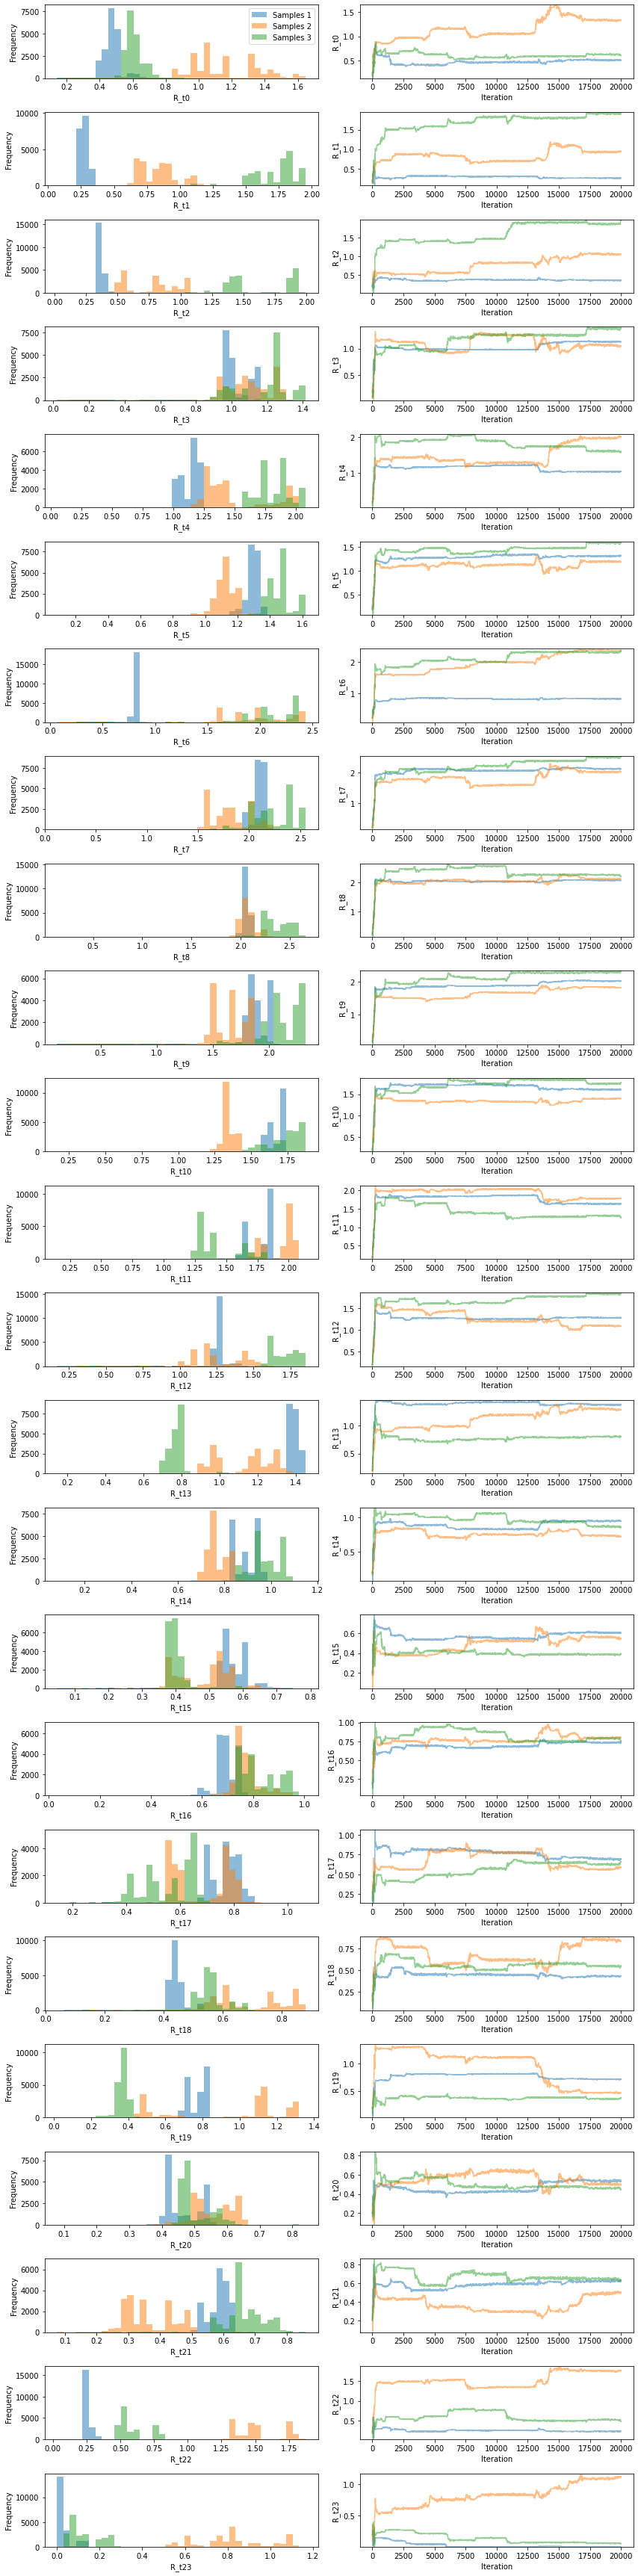

In [14]:
samples = inference.run_inference(num_iter=20000)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 10000:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, 1:], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, 1:], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, 1:], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [10]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

